# Data Processing

The purpose of this notebook is to process the data and keep it separate from the main analysis and visualization. We will write the code unnecessary for the user to interact with such as functions, import libraries, and processing the data into sheets of data we can interpret.

## Table of Contents
* content

## Notebooks
* [Overview Notebook](airpollution.ipynb)
* [Processing Notebook](dataprocessing.ipynb)
* [Analysis Notebook](data-analysis.ipynb)

## Import Libraries

Here are the libraries we are going to use to graph and analyze our data.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from glob import glob
from matplotlib.pyplot import figure 
import datetime
import geopandas
from datetime import datetime
from datetime import timedelta
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
from bokeh.io import output_file, show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure

## Functions

Here are the functions we have created to analyze the datasets we are looking at and graph them to display trends and comparisons.

In [2]:
def concatinate(path):
    files = glob(path + '*csv')
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        df['source_file'] = f.split('/')[-1]
        dfs.append(df)
    
    data = pd.concat(dfs)
    data.columns = ['date', 'source_ozone_aqi', 'ozone_aqi',
                    'source_pm25_aqi', 'pm25_aqi', 'file']
    
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values('date').reset_index(drop=True)
    return data

def rolling_mean(df, series_name, z = 30):
    s = df[['date', series_name]].dropna()
    col = '{}_smoothed'.format(series_name)
    s[col] = s[series_name].rolling(window=z).mean()
    return df.merge(s[['date', col]], how='left')
    return data

def missing_time_analysis(df, series_name):
    print('\nAnalyzing missing time series data for "{}"'.format(series_name))
    s = df[['date', series_name]].dropna()
    s['delta_t'] = s['date'].diff()
    s['delta_days'] = s['delta_t'].apply(lambda t: t.days)
    display(s.head(5))
    s.delta_days.hist(bins=50)
    plt.title('Time Gaps (days)')
    plt.show()
    display(s['delta_days'].describe())
    display(s[s.delta_days > 5]) # show any gaps larger than 5 days
    display(s[s['delta_days'] > 5].groupby('delta_days').size())
        

def aqi_plot(x, y, z): 
    
    temp = ['7/1/1985', '7/1/1986', '7/1/1987', '7/1/1988', '7/1/1989', '7/1/1990', '7/1/1991', '7/1/1992',
        '7/1/1993', '7/1/1994', '7/1/1995', '7/1/1996', '7/1/1997', '7/1/1998', '7/1/1999', '7/1/2000',
        '7/1/2001', '7/1/2002', '7/1/2003', '7/1/2004', '7/1/2005', '7/1/2006', '7/1/2007', '7/1/2008',
        '7/1/2009', '7/1/2010', '7/1/2011', '7/1/2012', '7/1/2013', '7/1/2014', '7/1/2015', '7/1/2016',
        '7/1/2017', '7/1/2018', '7/1/2019', '7/1/2020']

    x['date'] = pd.to_datetime(x['date'])
    y['date'] = pd.to_datetime(temp)
    data = pd.merge(x, y, how = 'left', on = 'date')

    fig, ax = plt.subplots(figsize = (16, 10))
    s = data[['date', 'Annual Ozone']].dropna()
    t = data[['date', 'Annual PM2.5']].dropna()
    ax.plot(data['date'], data['ozone_aqi_smoothed'], alpha = 0.3)
    ax.plot(data['date'], data['pm25_aqi_smoothed'], alpha = 0.3)
    ax.plot(s['date'], s['Annual Ozone'])
    ax.plot(t['date'], t['Annual PM2.5'])
    
    ax.set_title(z + ' Air Quality Trend', fontsize=18)
    ax.set_xlabel('Time (1985-2020)', fontsize=14)
    ax.set_ylabel('Average AQI', fontsize=14)
    ax.legend(['Seasonal Ozone', 'Seasonal PM2.5', 'Annual Ozone', 'Annual PM2.5'], prop={'size': 14})
    ax.grid()

def year_plot(x, y):
    data = x
    data['ozone_aqi'] = x['Ozone_AQI_Value'].rolling(window=30).mean()
    data['pm25_aqi'] = x['PM2.5_AQI_Value'].rolling(window=30).mean()
    
    ax = data.plot.line('Date', ['ozone_aqi', 'pm25_aqi'], figsize = (16, 10), colormap = 'Paired',
                     label = ['Ozone', 'PM 2.5'])
    ax.set_title(y + 'Air Quality Trend', fontsize = 18)
    ax.set_xlabel('Time (2020)', fontsize = 14)
    ax.set_ylabel('AQI', fontsize = 14)
    ax.legend(prop = {'size' : 14})
    ax.grid()
    
def plot_all(x):
    

    data = x[0]
    
   
    for f in range (1, len(x)):
        data = pd.merge(data, x[f], how = 'inner', on = 'date')
    ax = data.plot.line('date', ['ozone_aqi_smoothed_x', 
                                 'ozone_aqi_smoothed_y', 'ozone_aqi_smoothed'], figsize = (20, 10), title = 'Ozone Quality Trend', colormap = 'Paired')
    ax.set_xlabel('Time (1985-2020)')
    ax.set_ylabel('Average AQI')
    ax.legend(['NY-NJ-PA', 'TX', 'MA-NH', 'CA', 'PA-NJ-DE-MD', 'WA', 'MN-WI', 'IL-IN-WI', 'GA', 
              'MI', 'FL', 'AZ', 'DC-VA-MD-WV', 'CO', 'MO-IL'])
    ax.grid(True)
    
    bx = data.plot.line('date', ['pm25_aqi_smoothed_x',
                                 'pm25_aqi_smoothed_y', 'pm25_aqi_smoothed'], figsize = (20, 10), title = 'Particulate Matter Quality Trend', colormap = 'Paired')
    bx.set_xlabel('Time (1985-2020)')
    bx.set_ylabel('Average AQI')
    bx.legend(['NY-NJ-PA', 'TX', 'MA-NH', 'CA', 'PA-NJ-DE-MD', 'WA', 'MN-WI', 'IL-IN-WI', 'GA', 
              'MI', 'FL', 'AZ', 'DC-VA-MD-WV', 'CO', 'MO-IL'])
    bx.grid(True)

def production_data(x, z):

    y = x
    file = [z, z, z, z, z]
    goods = ['Gasoline', 'Fuel oils', 'Coal n.e.c', 'Motorized vehicles', 'Transport equipment', 'Machinery'
                   , 'Chemical products', 'Newsprint/paper', 'Printed products']

    y = y.sort_values(by = ['ID SCTG2', 'Year'], ascending = True)

    gasoline_index = [y.loc[y['SCTG2'] == 'Gasoline'].index.values.tolist()]
    gasoline = []
    for i in range (5):
        gasoline.append(x.iat[gasoline_index[0][i], 4])
    
    fuel_oils_index = [y.loc[y['SCTG2'] == 'Fuel oils'].index.values.tolist()]
    fuel_oils = []
    for i in range (5):
        fuel_oils.append(x.iat[fuel_oils_index[0][i], 4])
        
    coal_nec_index = [y.loc[y['SCTG2'] == 'Coal-n.e.c.'].index.values.tolist()]
    coal_nec = []
    for i in range (5):
        coal_nec.append(x.iat[coal_nec_index[0][i], 4])

    motorized_vehicles_index = [y.loc[y['SCTG2'] == 'Motorized vehicles'].index.values.tolist()]
    motorized_vehicles = []
    for i in range (5):
        motorized_vehicles.append(x.iat[motorized_vehicles_index[0][i], 4])
    
    transport_equipment_index = [y.loc[y['SCTG2'] == 'Transport equip.'].index.values.tolist()]
    transport_equipment = []
    for i in range (5):
        transport_equipment.append(x.iat[transport_equipment_index[0][i], 4])
    
    machinery_index = [y.loc[y['SCTG2'] == 'Machinery'].index.values.tolist()]
    machinery = []
    for i in range (5):
        machinery.append(x.iat[machinery_index[0][i], 4])
        
    
    newsprint_paper_index = [y.loc[y['SCTG2'] == 'Newsprint/paper'].index.values.tolist()]
    newsprint_paper = []
    for i in range (5):
        newsprint_paper.append(x.iat[newsprint_paper_index[0][i], 4])
    
    printed_products_index = [y.loc[y['SCTG2'] == 'Printed prods.'].index.values.tolist()]
    printed_products = []
    for i in range (5):
        printed_products.append(x.iat[printed_products_index[0][i], 4])
        
        
    time = ['2012', '2013', '2014', '2015', '2020']
    
    df = pd.DataFrame({'date' : time,
                       'Gasoline' : gasoline, 
                       'Fuel oils' : fuel_oils,
                       'Coal n.e.c.' : coal_nec,
                       'Motorized vehicles' : motorized_vehicles,
                       'Transport equipment' : transport_equipment,
                       'Machinery' : machinery,
                       'Newsprint paper' : newsprint_paper,
                       'Printed products' : printed_products,
                       'Area' : z})
    
    df['date'] = pd.to_datetime(df['date'])
    return df

def production_graph(x, z):
    x['date'] = x['date'].dt.strftime('%Y')
    bx = x.plot.bar('date', ['Gasoline', 'Fuel oils', 'Coal n.e.c.', 'Motorized vehicles', 'Transport equipment',
                          'Machinery', 'Newsprint paper', 'Printed products'], figsize = (15, 10), title = z, ylim = (0, 300000))
    bx.set_xlabel('Year')
    bx.set_ylabel('Millions of Dollars')
    bx.grid(True)
    bx.legend(['Gasoline', 'Fuel oils', 'Coal n.e.c', 'Motorized vehicles', 'Transport equipment', 'Machinery',
                'Newsprint/paper', 'Printed products'])
    
def msa_drop(x):
    data = x
    data.drop(data[(data['NAME'] != 'New York-Newark-Jersey City, NY-NJ-PA') &
                 (data['NAME'] != 'Los Angeles-Long Beach-Anaheim, CA') &
                 (data['NAME'] != 'Chicago-Naperville-Elgin, IL-IN-WI') &
                 (data['NAME'] != 'Dallas-Fort Worth-Arlington, TX') &
                 (data['NAME'] != 'Washington-Arlington-Alexandria, DC-VA-MD-WV') &
                 (data['NAME'] != 'Miami-Fort Lauderdale-Pompano Beach, FL') &
                 (data['NAME'] != 'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD') &
                 (data['NAME'] != 'Atlanta-Sandy Springs-Alpharetta, GA') &
                 (data['NAME'] != 'Phoenix-Mesa-Chandler, AZ') &
                 (data['NAME'] != 'Boston-Cambridge-Newton, MA-NH') &
                 (data['NAME'] != 'Detroit-Warren-Dearborn, MI') &
                 (data['NAME'] != 'Seattle-Tacoma-Bellevue, WA') &
                 (data['NAME'] != 'Minneapolis-St. Paul-Bloomington, MN-WI') &
                 (data['NAME'] != 'Denver-Aurora-Lakewood, CO') &
                 (data['NAME'] != 'St. Louis, MO-IL')].index, inplace=True)
    return data

def aqi_annual_average(area, abbr):
    
    year = []
    ozone_aqi = []
    pm25_aqi = []
    for i in range(1985, 2021):
        file = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Areas/' + area + '/' + str(i) + '-' + abbr + '.csv')
        year.append(str(i))
        ozone_aqi.append([file['Ozone_AQI_Value'].mean()])
        pm25_aqi.append([file['PM2.5_AQI_Value'].mean()])
    data = pd.DataFrame({'date' : year,
                         'Annual Ozone' : ozone_aqi,
                         'Annual PM2.5' : pm25_aqi})
    data['date'] = pd.to_datetime(data['date'])
    data['Annual Ozone'] = data['Annual Ozone'].str[0]
    data['Annual PM2.5'] = data['Annual PM2.5'].str[0]
    return data

def correlation(df):    
    plt.figure(figsize=(10,10))
    corrMatrix = df.corr()
    #matrix = np.triu(df.corr())
    sns.heatmap(corrMatrix, annot=True, fmt = '.1g', cmap = 'coolwarm', linewidths = 1, 
                linecolor = 'black', square = True)
    plt.title('Correlation Matrix')
    plt.show()
    
def annual_list(x, y):
    ozone = []
    pm25 = []
    for f in range (len(x)):
        ozone.append(x[f].iat[27, 1])
        ozone.append(x[f].iat[28, 1])
        ozone.append(x[f].iat[29, 1])
        ozone.append(x[f].iat[30, 1])
        ozone.append(x[f].iat[35, 1])
        
        pm25.append(x[f].iat[27, 2])
        pm25.append(x[f].iat[28, 2])
        pm25.append(x[f].iat[29, 2])
        pm25.append(x[f].iat[30, 2])
        pm25.append(x[f].iat[35, 2])
        
    df = pd.DataFrame({'Year' : y['date'],
                       'O3' : ozone,
                       'PM2.5' : pm25})
    return df

## Processing The Data

Here we access the file locations for each metropolitan statistical area and use the methods to create dataframes we can work with so we can plot them.

In [3]:
ny_nj_pa_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/NewYork-Newark-JerseyCity/')
ny_nj_pa = rolling_mean(ny_nj_pa_files, 'ozone_aqi')
ny_nj_pa = rolling_mean(ny_nj_pa, 'pm25_aqi')
ny_nj_pa_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/NY-NJ-PA-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
ny_nj_pa_production = production_data(ny_nj_pa_production_files, 'NY-NJ-PA')
ny_nj_pa_annual = aqi_annual_average('NewYork-Newark-JerseyCity', 'NY-NJ-PA')
#below is the file test to use for graphing one year of plotting (ex checking 2020)
#ny_nj_pa_2020 = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Areas/NewYork-Newark-JerseyCity/2020-NY-NJ-PA.csv')


il_in_wi_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Chicago-Naperville-Elgin/')
il_in_wi = rolling_mean(il_in_wi_files, 'ozone_aqi')
il_in_wi = rolling_mean(il_in_wi, 'pm25_aqi')
il_in_wi_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/IL-IN-WI-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
il_in_wi_production = production_data(il_in_wi_production_files, 'IL-IN-WI')
il_in_wi_annual = aqi_annual_average('Chicago-Naperville-Elgin', 'IL-IN-WI')

tx_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Dallas-FortWorth-Arlington/')
tx = rolling_mean(tx_files, 'ozone_aqi')
tx = rolling_mean(tx, 'pm25_aqi')
tx_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/TX-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
tx_production = production_data(tx_production_files, 'TX')
tx_annual = aqi_annual_average('Dallas-FortWorth-Arlington', 'TX')

ga_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Atlanta-SandySprings-Roswell/')
ga = rolling_mean(ga_files, 'ozone_aqi')
ga = rolling_mean(ga, 'pm25_aqi')
ga_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/GA-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
ga_production = production_data(ga_production_files, 'GA')
ga_annual = aqi_annual_average('Atlanta-SandySprings-Roswell', 'GA')

ma_nh_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Boston-Cambridge-Newton/')
ma_nh = rolling_mean(ma_nh_files, 'ozone_aqi')
ma_nh = rolling_mean(ma_nh, 'pm25_aqi')
ma_nh_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/MA-NH-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
ma_nh_production = production_data(ma_nh_production_files, 'MA-NH')
ma_nh_annual = aqi_annual_average('Boston-Cambridge-Newton', 'MA-NH')

mi_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Detroit-Warren-Dearborn/')
mi = rolling_mean(mi_files, 'ozone_aqi')
mi = rolling_mean(mi, 'pm25_aqi')
mi_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/MI-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
mi_production = production_data(mi_production_files, 'MI')
mi_annual = aqi_annual_average('Detroit-Warren-Dearborn', 'MI')
# year test: mi_2020 = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Detroit-Warren-Dearborn/2020-MI.csv')

ca_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/LosAngeles-LongBeach-Anaheim/')
ca = rolling_mean(ca_files, 'ozone_aqi')
ca = rolling_mean(ca, 'pm25_aqi')
ca_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/CA-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
ca_production = production_data(ca_production_files, 'CA')
ca_annual = aqi_annual_average('LosAngeles-LongBeach-Anaheim', 'CA')

fl_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Miami-FortLauderdale-WestPalmBeach/')
fl = rolling_mean(fl_files, 'ozone_aqi')
fl = rolling_mean(fl, 'pm25_aqi')
fl_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/FL-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
fl_production = production_data(fl_production_files, 'FL')
fl_annual = aqi_annual_average('Miami-FortLauderdale-WestPalmBeach', 'FL')

pa_nj_de_md_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Philadelphia-Camden-Wilmington/')
pa_nj_de_md = rolling_mean(pa_nj_de_md_files, 'ozone_aqi')
pa_nj_de_md = rolling_mean(pa_nj_de_md, 'pm25_aqi')
pa_nj_de_md_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/PA-NJ-DE-MD-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
pa_nj_de_md_production = production_data(pa_nj_de_md_production_files, 'PA-NJ-DE-MD')
pa_nj_de_md_annual = aqi_annual_average('Philadelphia-Camden-Wilmington', 'PA-NJ-DE-MD')

az_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Phoenix-Mesa-Scottsdale/')
az = rolling_mean(az_files, 'ozone_aqi')
az = rolling_mean(az, 'pm25_aqi')
az_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/AZ-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
az_production = production_data(az_production_files, 'AZ')
az_annual = aqi_annual_average('Phoenix-Mesa-Scottsdale', 'AZ')
# year test: az_2020 = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Phoenix-Mesa-Scottsdale/2020-AZ.csv')

wa_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Seattle-Tacoma-Bellevue/')
wa = rolling_mean(wa_files, 'ozone_aqi')
wa = rolling_mean(wa, 'pm25_aqi')
wa_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/WA-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
wa_production = production_data(wa_production_files, 'WA')
wa_annual = aqi_annual_average('Seattle-Tacoma-Bellevue', 'WA')

dc_va_md_wv_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Washington-Arlington-Alexandria/')
dc_va_md_wv = rolling_mean(dc_va_md_wv_files, 'ozone_aqi')
dc_va_md_wv = rolling_mean(dc_va_md_wv, 'pm25_aqi')
dc_va_md_wv_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/DC-VA-MD-WV-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
dc_va_md_wv_production = production_data(dc_va_md_wv_production_files, 'DC-VA-MD-WV')
dc_va_md_wv_annual = aqi_annual_average('Washington-Arlington-Alexandria', 'DC-VA-MD-WV')

mn_wi_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Minneapolis-St.Paul-Bloomington/')
mn_wi = rolling_mean(mn_wi_files, 'ozone_aqi')
mn_wi = rolling_mean(mn_wi, 'pm25_aqi')
mn_wi_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/MN-WI-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
mn_wi_production = production_data(mn_wi_production_files, 'MN-WI')
mn_wi_annual = aqi_annual_average('Minneapolis-St.Paul-Bloomington', 'MN-WI')

co_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Denver-Aurora-Lakewood/')
co = rolling_mean(co_files, 'ozone_aqi')
co = rolling_mean(co, 'pm25_aqi')
co_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/CO-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
co_production = production_data(co_production_files, 'CO')
co_annual = aqi_annual_average('Denver-Aurora-Lakewood', 'CO')                                  
# year test: co_2020 = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Denver-Aurora-Lakewood/2020-CO.csv')

mo_il_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/St.Louis/')
mo_il = rolling_mean(mo_il_files, 'ozone_aqi')
mo_il = rolling_mean(mo_il, 'pm25_aqi')
mo_il_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/MO-IL-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
mo_il_production = production_data(mo_il_production_files, 'MO-IL')
mo_il_annual = aqi_annual_average('St.Louis', 'MO-IL')

areas = [ny_nj_pa, il_in_wi, tx, ga, ma_nh, mi, ca, fl, pa_nj_de_md, az, wa, dc_va_md_wv, mn_wi, co, mo_il]
time = ['2012', '2013', '2014', '2015', '2020']

production = [ny_nj_pa_production, il_in_wi_production, tx_production, ga_production, ma_nh_production,
              mi_production, ca_production, fl_production, pa_nj_de_md_production, az_production, wa_production,
              dc_va_md_wv_production, mn_wi_production, co_production, mo_il_production]
production = pd.concat(production)
annual = [ny_nj_pa_annual, il_in_wi_annual, tx_annual, ga_annual, ma_nh_annual, mi_annual, ca_annual,
          fl_annual, pa_nj_de_md_annual, az_annual, wa_annual, dc_va_md_wv_annual, mn_wi_annual, co_annual,
          mo_il_annual]
annual = annual_list(annual, production)
production['O3'] = annual['O3']
production['PM2.5'] = annual['PM2.5']

msa = geopandas.read_file('/Users/smaslam/Desktop/airpollution/airpollution/CBSAMap/tl_2019_us_cbsa.shp')
msa = msa_drop(msa)
us = geopandas.read_file('/Users/smaslam/Desktop/airpollution/airpollution/US/cb_2016_us_state_500k.shp')


### Simulation Functions

Functions for the simulation of the map!

In [4]:
def plot_year_aqi(msa, index, p, year, us):
    msa_names = ['GA', 'MA-NH', 'TX', 'CO', 'MI', 'IL-IN-WI', 'CA', 'FL', 
             'MN-WI', 'NY-NJ-PA','PA-NJ-DE-MD','AZ', 'MO-IL', 'WA', 'DC-VA-MD-WV']
    msa['NAMELSAD'] = msa_names
    
    aqi = [ga_annual.iloc[index, p], ma_nh_annual.iloc[index, p], tx_annual.iloc[index, p], 
               co_annual.iloc[index, p], mi_annual.iloc[index, p], il_in_wi_annual.iloc[index, p], 
               ca_annual.iloc[index, p], fl_annual.iloc[index, p], mn_wi_annual.iloc[index, p], 
               ny_nj_pa_annual.iloc[index, p], pa_nj_de_md_annual.iloc[index, p], 
               az_annual.iloc[index, p], mo_il_annual.iloc[index, p], wa_annual.iloc[index, p], 
               dc_va_md_wv_annual.iloc[index, p]]  
    temp = pd.DataFrame({'NAMELSAD' : msa_names,
                          year : aqi})
    display = pd.merge(msa, temp, how = 'left', on = 'NAMELSAD')
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    fig.set_figheight(20)
    fig.set_figwidth(20)
    ax.set_ylim([23, 50])
    ax.set_xlim([-130,-60])
    ax.set_title(year + ' MSA Air Quality', fontsize = 20)
    ax.set_axis_off()
    us.plot(ax=ax, color='white', edgecolor='k')
    divider = make_axes_locatable(ax)
    display.plot(ax = ax, alpha = 0.3, edgecolor = 'k', column = year, legend = True,
                       cax = divider.append_axes("right", size="5%", pad=0.1))
    plt.show()

In [5]:
def simulation(msa, us):
    year = ''
    while(year != 'STOP'):
        year = input('Enter a year from 1985-2020 to see the AQI, or type STOP to stop the simulation: ' )
        if year != 'STOP':
            pollutant = input('Enter O3 or PM2.5 to see the year AQI for that pollutant: ')
            if year == '1985' and pollutant == 'O3':
                plot_year_aqi(msa, 0, 1, year, us)
            elif year == '1985' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 0, 2, year, us)
            elif year == '1986' and pollutant == 'O3':
                plot_year_aqi(msa, 1, 1, year, us)
            elif year == '1986' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 1, 2, year, us)
            elif year == '1987' and pollutant == 'O3':
                plot_year_aqi(msa, 2, 1, year, us)
            elif year == '1987' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 2, 2, year, us)
            elif year == '1988' and pollutant == 'O3':
                plot_year_aqi(msa, 3, 1, year, us)
            elif year == '1988' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 3, 2, year, us)
            elif year == '1989' and pollutant == 'O3':
                plot_year_aqi(msa, 4, 1, year, us)
            elif year == '1989' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 4, 2, year, us)
            elif year == '1990' and pollutant == 'O3':
                plot_year_aqi(msa, 5, 1, year, us)
            elif year == '1990' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 5, 2, year, us)
            elif year == '1991' and pollutant == 'O3':
                plot_year_aqi(msa, 6, 1, year, us)
            elif year == '1991' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 6, 2, year, us)
            elif year == '1992' and pollutant == 'O3':
                plot_year_aqi(msa, 7, 1, year, us)
            elif year == '1992' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 7, 2, year, us)
            elif year == '1993' and pollutant == 'O3':
                plot_year_aqi(msa, 8, 1, year, us)
            elif year == '1993' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 8, 2, year, us)
            elif year == '1994' and pollutant == 'O3':
                plot_year_aqi(msa, 9, 1, year, us)
            elif year == '1994' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 9, 2, year, us)
            elif year == '1995' and pollutant == 'O3':
                plot_year_aqi(msa, 10, 1, year, us)
            elif year == '1995' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 10, 2, year, us)
            elif year == '1996' and pollutant == 'O3':
                plot_year_aqi(msa, 11, 1, year, us)
            elif year == '1996' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 11, 2, year, us)
            elif year == '1997' and pollutant == 'O3':
                plot_year_aqi(msa, 12, 1, year, us)
            elif year == '1997' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 12, 2, year, us)
            elif year == '1998' and pollutant == 'O3':
                plot_year_aqi(msa, 13, 1, year, us)
            elif year == '1998' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 13, 2, year, us)
            elif year == '1999' and pollutant == 'O3':
                plot_year_aqi(msa, 14, 1, year, us)
            elif year == '1999' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 14, 2, year, us)
            elif year == '2000' and pollutant == 'O3':
                plot_year_aqi(msa, 15, 1, year, us)
            elif year == '2000' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 15, 2, year, us)
            elif year == '2001' and pollutant == 'O3':
                plot_year_aqi(msa, 16, 1, year, us)
            elif year == '2001' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 16, 2, year, us)
            elif year == '2002' and pollutant == 'O3':
                plot_year_aqi(msa, 17, 1, year, us)
            elif year == '2002' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 17, 2, year, us)
            elif year == '2003' and pollutant == 'O3':
                plot_year_aqi(msa, 18, 1, year, us)
            elif year == '2003' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 18, 2, year, us)
            elif year == '2004' and pollutant == 'O3':
                plot_year_aqi(msa, 19, 1, year, us)
            elif year == '2004' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 19, 2, year, us)
            elif year == '2005' and pollutant == 'O3':
                plot_year_aqi(msa, 20, 1, year, us)
            elif year == '2005' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 20, 2, year, us)
            elif year == '2006' and pollutant == 'O3':
                plot_year_aqi(msa, 21, 1, year, us)
            elif year == '2006' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 21, 2, year, us)
            elif year == '2007' and pollutant == 'O3':
                plot_year_aqi(msa, 22, 1, year, us)
            elif year == '2007' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 22, 2, year, us)
            elif year == '2008' and pollutant == 'O3':
                plot_year_aqi(msa, 23, 1, year, us)
            elif year == '2008' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 23, 2, year, us)
            elif year == '2009' and pollutant == 'O3':
                plot_year_aqi(msa, 24, 1, year, us)
            elif year == '2009' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 24, 2, year, us)
            elif year == '2010' and pollutant == 'O3':
                plot_year_aqi(msa, 25, 1, year, us)
            elif year == '2010' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 25, 2, year, us)
            elif year == '2011' and pollutant == 'O3':
                plot_year_aqi(msa, 26, 1, year, us)
            elif year == '2011' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 26, 2, year, us)
            elif year == '2012' and pollutant == 'O3':
                plot_year_aqi(msa, 27, 1, year, us)
            elif year == '2012' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 27, 2, year, us)
            elif year == '2013' and pollutant == 'O3':
                plot_year_aqi(msa, 28, 1, year, us)
            elif year == '2013' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 28, 2, year, us)
            elif year == '2014' and pollutant == 'O3':
                plot_year_aqi(msa, 29, 1, year, us)
            elif year == '2014' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 29, 2, year, us)
            elif year == '2015' and pollutant == 'O3':
                plot_year_aqi(msa, 30, 1, year, us)
            elif year == '2015' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 30, 2, year, us)
            elif year == '2016' and pollutant == 'O3':
                plot_year_aqi(msa, 31, 1, year, us)
            elif year == '2016' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 31, 2, year, us)
            elif year == '2017' and pollutant == 'O3':
                plot_year_aqi(msa, 32, 1, year, us)
            elif year == '2017' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 32, 2, year, us)
            elif year == '2018' and pollutant == 'O3':
                plot_year_aqi(msa, 33, 1, year, us)
            elif year == '2018' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 33, 2, year, us)
            elif year == '2019' and pollutant == 'O3':
                plot_year_aqi(msa, 34, 1, year, us)
            elif year == '2019' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 34, 2, year, us)
            elif year == '2020' and pollutant == 'O3':
                plot_year_aqi(msa, 35, 1, year, us)
            elif year == '2020' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 35, 2, year, us)

Enter a year from 1985-2020 to see the AQI, or type STOP to stop the simulation: 1987
Enter O3 or PM2.5 to see the year AQI for that pollutant: O3


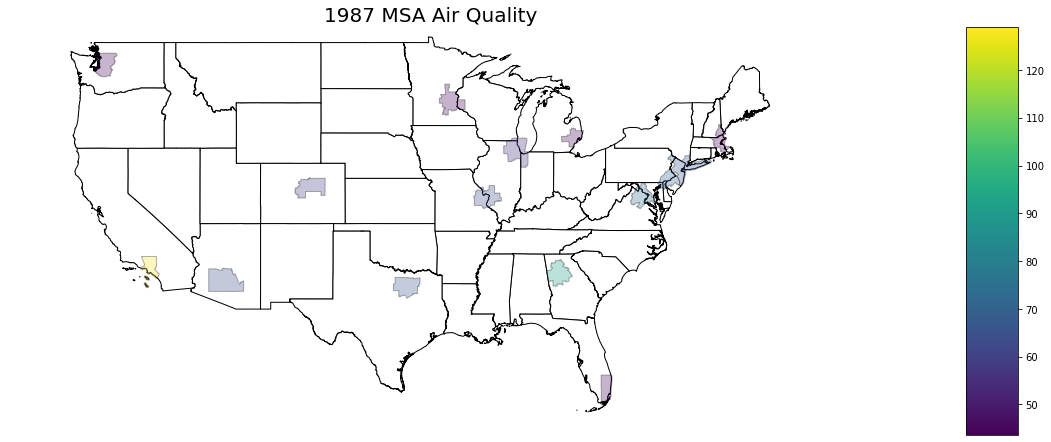

Enter a year from 1985-2020 to see the AQI, or type STOP to stop the simulation: 2020


In [ ]:
simulation(msa, us)

Attempt at using JSON for Slider

In [ ]:
#msa1985 = GeoJSONDataSource(geojson = msa_1985.to_json())
#unitedstates = GeoJSONDataSource(geojson = us.to_json())
#p = figure(title = 'MSA Air Quality', 
#           plot_height = 600 ,
#           plot_width = 950, 
#           toolbar_location = 'below',
#           tools = 'pan, wheel_zoom, box_zoom, reset')
#p.xgrid.grid_line_color = None
#p.ygrid.grid_line_color = None

#msas = p.patches('xs','ys', source = msa1985,
#                   fill_color = None,
#                   line_color = 'black', 
#                   line_width = 0.25, 
#                   fill_alpha = 1)

#states = p.patches('xs','ys', source = unitedstates,
#                  fill_color = None,
#                  line_color = 'black', 
#                  line_width = 0.25, 
#                  fill_alpha = 1)

#p.add_tools(HoverTool(renderers = [msas, states],
#                     tooltips = [('MSA','@NAME'),
#                               ('AQI','@1985'), ('States', '@NAME')]))
#show(p)
